In [1]:
import numpy as np
from scipy.linalg import logm, expm
import matplotlib.pyplot as plt
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [2]:
def plot_cylinder(ax):
    theta = np.linspace(0, 2 * np.pi, 100) 
    #horizontal cylinder
    x_cylinder_horizontal = np.linspace(0.57, 0.82, 100)  # Extent of cylinder along X
    y_cylinder_horizontal = 0.025 * np.sin(theta)
    z_cylinder_horizontal = 0.025 * np.cos(theta) 
    y_cylinder_horizontal+=0.095
    z_cylinder_horizontal+=0.025
    ax.plot_surface(x_cylinder_horizontal[:, None], y_cylinder_horizontal[None, :], #prosoxh sta none!
                    z_cylinder_horizontal[None, :], color='orange', alpha=0.3)


In [3]:
def box_plot(ax):
    # box
    length_cm = 0.40  # x
    width_cm = 0.20   # y
    height_cm = 0.20  # z

    # Translation vector to move the box to (x=30, y=40) for its edge at (0, 0, 0)
    box_translation = np.array([0.30, 0.40, 0])

    # Define the vertices
    vertices = np.array([[0, 0, 0],
                        [length_cm, 0, 0],
                        [length_cm, width_cm, 0],
                        [0, width_cm, 0],
                        [0, 0, height_cm],
                        [length_cm, 0, height_cm],
                        [length_cm, width_cm, height_cm],
                        [0, width_cm, height_cm]])

    # Define the six faces (by connecting the vertices)
    faces = [[vertices[0], vertices[1], vertices[2], vertices[3]],  # Bottom
            [vertices[4], vertices[5], vertices[6], vertices[7]],  # Top
            [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front
            [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back
            [vertices[1], vertices[2], vertices[6], vertices[5]],  # Right
            [vertices[0], vertices[3], vertices[7], vertices[4]]]  +box_translation# Left

    # Create the box using Poly3DCollection with red color and semi-transparent surface
    ax.add_collection3d(Poly3DCollection(faces, facecolors='r', linewidths=1, edgecolors='k', alpha=0.1))

    # Create the cylinder (radius 5, height 40) in the center of the box
    theta = np.linspace(0, 2 * np.pi, 100)
    z_cylinder = np.linspace(0, height_cm, 100)
    x_cylinder = 0.05 * np.cos(theta)
    y_cylinder = 0.05 * np.sin(theta)

    x_cylinder += 0.50
    y_cylinder += 0.50

    # Plot the cylinder in the box (this gives the effect of a hole)
    ax.plot_surface(x_cylinder[None, :], y_cylinder[None, :], z_cylinder[:, None], color='0.1', alpha=0.1)

In [4]:
def cubic_spline_se3(T_s, T_g, T, num_points, V_s=np.zeros((4, 4)), V_g=np.zeros((4, 4))):
    '''T_s=start'''
    # Compute the matrix logarithms of the transformations
    tau_s = logm(T_s) # log(Rs_)=φs
    tau_g = logm(T_g) #

    # Compute spline coefficients
    c0 = tau_s # log(Rs_)=φs
    c1 = V_s   #ωs
    c2 = (3 / T**2) * (tau_g - tau_s) - (2 / T) * V_s - (1 / T) * V_g # 3(φg-φs)/T^2-2ωs/T-ωg/T
    c3 = (-2 / T**3) * (tau_g - tau_s) + (1 / T**2) * (V_s + V_g) # -2(φg-φs)/T^3+(ωs+ωg)/T^2

    # Time points
    time_points = np.linspace(0, T, num_points)

    # Storage for results
    positions = [] 
    rotations = []
    transformations = []
    velocities = []

    # Generate trajectory
    for t in time_points:
        # Compute intermediate transformation
        tau_t = c0 + c1 * t + c2 * t**2 + c3 * t**3
        T_t = expm(tau_t) # T(t)=exp(φ(t)) pg23 lec 7

        # Compute intermediate velocity
        V_t = (3 * c3 * t**2 + 2 * c2 * t + c1) @ T_t # V(t)=d/dt(T(t))=d/dt(exp(φ(t)))=d/dt(φ(t))exp(φ(t))=ω(t)T(t)

        # Store results
        positions.append(T_t[:3, 3]) # column 3 first 3 rows
        rotations.append(T_t[:3, :3]) # first 3 rows first 3 columns
        transformations.append(T_t) # T(t)
        velocities.append(V_t) # V(t)

    return np.array(positions), np.array(rotations), transformations, np.array(velocities)

In [5]:
# Define the start, goal, and hole transformations and velocities
T_s = np.array([
    [1, 0, 0, 0.088],
    [0, -1, 0, 0],
    [0, 0, -1, 0.926],
    [0, 0, 0, 1]
])

T_g = np.array([
    [1, 0, 0, 0.65],
    [0, -1, 0, 0.095],
    [0, 0, -1, 0.05],
    [0, 0, 0, 1]
])

T_h = np.array([
    [0, 0, 1, 0.45],
    [0, -1, 0, 0.5],
    [1, 0, 0, 0.35],
    [0, 0, 0, 1]
])

In [6]:
V_s = np.zeros((4, 4))  # Initial velocity (at rest)
V_g = np.zeros((4, 4))  # Final velocity at goal (at rest)
V_h = np.zeros((4, 4))  # Final velocity at hole (at rest)

# Generate trajectories
positions1, rotations1, transformations1, velocities1 = cubic_spline_se3(T_s, T_g,  T=10, num_points=50)
positions2, rotations2, transformations2, velocities2 = cubic_spline_se3(T_g, T_h,  T=10, num_points=50)

# Combine trajectories
positions = np.vstack((positions1, positions2))
rotations = np.vstack((rotations1, rotations2))
transformations = transformations1 + transformations2
velocities = velocities1 + velocities2

c:\Python311\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python311\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


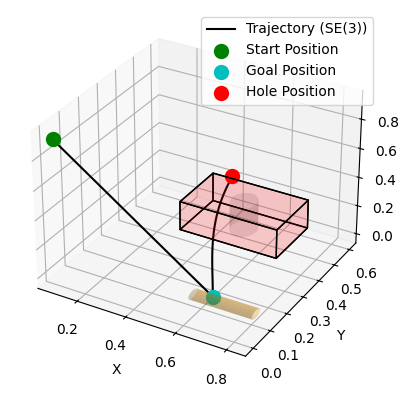

In [93]:
######################### QUESTION 5 #########################
# Visualize the trajectory #
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
box_plot(ax)
plot_cylinder(ax)
# Extract positions for plotting
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label="Trajectory (SE(3))", color="k")
ax.scatter(T_s[:3, 3][0], T_s[:3, 3][1], T_s[:3, 3][2], color='g', s=100, label='Start Position')
ax.scatter(T_g[:3, 3][0], T_g[:3, 3][1], T_g[:3, 3][2], color='c', s=100, label='Goal Position')
ax.scatter(T_h[:3, 3][0], T_h[:3, 3][1], T_h[:3, 3][2], color='r', s=100, label='Hole Position')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()


In [103]:
######################### QUESTION 6 #########################
# seperate script to allow for animation
# not convenient to run in jupyter notebook